We will use [tsfresh](https://tsfresh.readthedocs.io/) to create features. The module takes flat dataframes, as described [in the docs](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html).

We will take the UC Berkeley milling data set and create a flat dataframe from it.

In [27]:
import pathlib
from pathlib import Path
import scipy.io as sio
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
root_dir = Path.cwd().parent
print(root_dir)

folder_raw_data_milling = root_dir / 'data/raw/milling'
print(folder_raw_data_milling)

/home/tim/Documents/feat-store
/home/tim/Documents/feat-store/data/raw/milling


In [18]:
# extract mill.zip if not already extracted
data_path = folder_raw_data_milling / 'mill.mat'
if not data_path.exists():
    with zipfile.ZipFile(folder_raw_data_milling / 'mill.zip', 'r') as zip_ref:
        zip_ref.extractall(folder_raw_data_milling)

In [23]:
# load the data from the matlab file
m = sio.loadmat(data_path, struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

Get an idea of the stucture of the data array.

In [24]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


In [25]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


Make a simple plot to look at some of the data.

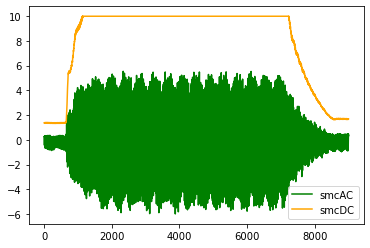

In [28]:
# look at cut number 167 (index 166)
fig, ax = plt.subplots()

ax.plot(data[0,166]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()

# Create a Milling Data Prep Class
Borrow shamelessly from previous work at [ml-tool-wear](https://github.com/tvhahn/ml-tool-wear).

tsfresh likes a dataframe, but deep learning models, like those build in PyTorch, like to work with arrays. Our class will create the numpy array first, and then produce a flat dataframe from that.

In [29]:
m = sio.loadmat(data_path, struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

field_names = data.dtype.names


In [ ]:
def create_tensor(
        data_sample, signal_names, start, end, window_size, stride=8
    ):
        """Create a tensor from a cut sample. Final tensor will have shape: 
        [# samples, # sample len, # features/sample]

        Parameters
        ===========
        data_sample : ndarray
            single data sample (individual cut) containing all the signals

        signal_names : tuple
            tuple of all the signals that will be added into the tensor

        start : int
            starting index (e.g. the first 2000 "samples" in the cut may be from
            when the tool is not up to speed, so should be ignored)

        end : int
            ending index
        
        window_size : int
            size of the window to be used to make the sub-cuts

        stride : int
            length to move the window at each iteration

        Returns
        ===========
        c : ndarray
            array of the sub-cuts

        """

        s = signal_names[::-1]  # only include the six signals, and reverse order
        c = data_sample[s[0]].reshape((9000, 1))

